In [1]:
import yfinance as yf
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import pymc as pm

In [2]:
nasdaq = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
nasdaq_tickers = pd.read_csv('https://www.nasdaqtrader.com/dynamic/SymDir/nasdaqtraded.txt', sep='|')
nasdaq_tickers.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAA,Alternative Access First Priority CLO Bond ETF,P,,Y,100.0,N,NaN,AAA,AAA,N
3,Y,AAAU,Goldman Sachs Physical Gold ETF Shares,Z,,Y,100.0,N,NaN,AAAU,AAAU,N
4,Y,AACB,Artius II Acquisition Inc. - Class A Ordinary ...,Q,G,N,100.0,N,N,NaN,AACB,N


In [3]:
import os
import pandas as pd
from tqdm import tqdm

if os.path.exists('ticker_data.csv'):
    final_df = pd.read_csv('ticker_data.csv')
else:
    final_df = pd.DataFrame(columns=['Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
not_found = []

for ticker in tqdm(sp500[0]['Symbol'].tolist()):
    if ticker in final_df['Ticker'].tolist():
        continue
    else:
        try:
            df = yf.download(ticker, start='2024-03-31', end='2025-05-28', multi_level_index=False, interval='1h')
            df['Ticker'] = ticker
            final_df = pd.concat([final_df, df])
            final_df.to_csv('ticker_data_hourly.csv', index = False)
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            not_found.append(ticker)


  6%|▋         | 32/503 [00:00<00:01, 315.67it/s]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRK.B']: HTTPError('HTTP Error 401: ')
/var/folders/zg/dk0qffx55tj5q4d2hvpp5m2c0000gn/T/ipykernel_53240/1056046994.py:18: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  final_df = pd.concat([final_df, df])
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1h 2024-03-31 -> 2025-05-28)')
/var/folders/zg/dk0qffx55tj5q4d2hvpp5m2c0000gn/T/ipykernel_53240/1056046994.py:18: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior,

In [4]:
warnings.filterwarnings('ignore', category=FutureWarning)


# Define columns to exclude
useless = ['address1',
 'city',
 'state',
 'zip',
 'country',
 'phone',
 'website',
 'industry',
 'industryKey',
 'industryDisp',
 'sector',
 'sectorKey',
 'sectorDisp',
 'longBusinessSummary',
 'fullTimeEmployees',
 'companyOfficers',
 'irWebsite',
 'executiveTeam',
 'maxAge',
 'fax',
 'displayName',
 'marketState',
 'longName',
 'exchangeTimezoneName',
 'exchangeTimezoneShortName'
 ]

# Initialize empty fundamentals dataframe
try:
    fundamentals = pd.read_csv('fundamentals.csv')
except:
    fundamentals = None

df = pd.read_csv('ticker_data.csv')
if fundamentals is None:
    fundamentals = pd.DataFrame()
    # Get fundamental data for each ticker
    for ticker in tqdm(df['Ticker'].unique(), desc='Getting fundamental data'):
        try:
            tick = yf.Ticker(ticker)
            info = tick.info
            
            # Get all keys except excluded ones
            keys = [key for key in info.keys() if key not in useless]
            values = [info[key] for key in keys]
            
            # Create temporary dataframe for this ticker
            ticker_df = pd.DataFrame([values], columns=keys)
            ticker_df['Ticker'] = ticker
            
            # Append to fundamentals dataframe
            fundamentals = pd.concat([fundamentals, ticker_df], ignore_index=True)
            fundamentals.to_csv('fundamentals.csv', index=False)
        except Exception as e:
            print(f"Error getting data for {ticker}: {e}")

        


In [26]:
[i for i in fundamentals.columns if 'name' in i.lower()]

['quoteSourceName',
 'shortName',
 'fullExchangeName',
 'prevName',
 'nameChangeDate']

In [5]:
cols = list(fundamentals.columns)
fundamentals = pd.read_csv('fundamentals.csv')
risks = [i for i in cols if 'Risk' in i]
risks_df = fundamentals[['Ticker']+risks]



fundamentals = fundamentals[cols]
add = [i for i in cols if (('date' in i.lower()) or ('time' in i.lower()))] 
remove = ['isEarningsDateEstimate','firstTradeDateMilliseconds','ipoExpectedDate','nameChangeDate']
from datetime import datetime
# Convert timestamp columns to datetime, handling each column separately
date_cols = [i for i in cols if ((i in add) and (i not in remove))]
relevant_dates = fundamentals[['Ticker']+date_cols]
for col in date_cols:
    relevant_dates[col] = relevant_dates[col].apply(lambda x: datetime.fromtimestamp(x) if pd.notnull(x) else x)
[cols.remove(i) for i in date_cols]


fundamentals[cols]
dividends = [i for i in cols if 'Dividend' in i]
dividends_df = fundamentals[['Ticker']+dividends]
dividends_df
[cols.remove(i) for i in dividends]

L1Y = [i for i in cols if 'fifty' in i]
L1Y_stats = fundamentals[['Ticker']+L1Y]
[cols.remove(i) for i in L1Y]



volume = [i for i in cols if 'volume' in i.lower()]
volume_df = fundamentals[['Ticker']+volume]
[cols.remove(i) for i in volume]

short = [i for i in cols if 'short' in i.lower()]
short_df = fundamentals[['Ticker']+short]
[cols.remove(i) for i in cols]
short_df

fund_df = fundamentals[cols]
fund_df
[cols.remove(i) for i in fund_df.columns]
print(f"""
risks_df: {risks_df.columns},
date_cols: {relevant_dates.columns}
dividends_df: {dividends_df.columns}
L1Y_stats: {L1Y_stats.columns}
volume_df: {volume_df.columns}
short_df: {short_df.columns}
fund_df: {fund_df.columns}
""")


risks_df: Index(['Ticker', 'auditRisk', 'boardRisk', 'compensationRisk',
       'shareHolderRightsRisk', 'overallRisk'],
      dtype='object'),
date_cols: Index(['Ticker', 'governanceEpochDate', 'compensationAsOfEpochDate',
       'exDividendDate', 'sharesShortPreviousMonthDate', 'dateShortInterest',
       'lastSplitDate', 'lastDividendDate', 'dividendDate',
       'earningsTimestamp', 'earningsTimestampStart', 'earningsTimestampEnd',
       'earningsCallTimestampStart', 'earningsCallTimestampEnd',
       'regularMarketTime'],
      dtype='object')
dividends_df: Index(['Ticker', 'fiveYearAvgDividendYield', 'trailingAnnualDividendRate',
       'trailingAnnualDividendYield', 'lastDividendValue'],
      dtype='object')
L1Y_stats: Index(['Ticker', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'fiftyDayAverage',
       'fiftyTwoWeekLowChange', 'fiftyTwoWeekLowChangePercent',
       'fiftyTwoWeekRange', 'fiftyTwoWeekHighChange',
       'fiftyTwoWeekHighChangePercent', 'fiftyTwoWeekChangePercent',

/var/folders/zg/dk0qffx55tj5q4d2hvpp5m2c0000gn/T/ipykernel_53240/837013037.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_dates[col] = relevant_dates[col].apply(lambda x: datetime.fromtimestamp(x) if pd.notnull(x) else x)


In [44]:
fundamentals[[
    'Ticker','shortName',
    'heldPercentInstitutions','floatShares','enterpriseValue',
    'fiftyTwoWeekChangePercent', 'fiftyDayAverageChangePercent',
    'revenueGrowth','netIncomeToCommon','operatingCashflow','returnOnAssets',
    'shortRatio','shortPercentOfFloat']].tail(1).to_dict()

{'Ticker': {449: 'UDR'},
 'shortName': {449: 'UDR, Inc.'},
 'heldPercentInstitutions': {449: 1.02897},
 'floatShares': {449: 299464934},
 'enterpriseValue': {449: 20166907904.0},
 'fiftyTwoWeekChangePercent': {449: 3.2975674},
 'fiftyDayAverageChangePercent': {449: -0.05352157},
 'revenueGrowth': {449: 0.012},
 'netIncomeToCommon': {449: 118346000},
 'operatingCashflow': {449: 865465024},
 'returnOnAssets': {449: 0.018029999},
 'shortRatio': {449: 1.9},
 'shortPercentOfFloat': {449: 0.021300001}}

In [10]:
# Sort the dataframe by 'Date' first, then group by 'Ticker' and show the first few rows
latest_df = df.sort_values('Date').groupby('Ticker').tail().drop(columns = ['Date','High','Low','Volume'])
feature_df = latest_df.merge(risks_df, on = 'Ticker', how = 'left')
feature_df['Percentage Change'] = (feature_df['Close'] - feature_df['Open'])/feature_df['Open']
feature_df.drop(columns = ['Open','Close'], inplace = True)
feature_df.set_index(['Ticker']).corr()*100

,Unnamed: 0,Unnamed: 0.1,Adj Close,auditRisk,boardRisk,compensationRisk,shareHolderRightsRisk,overallRisk,Percentage Change
Unnamed: 0,100.000000,100.000000,NaN,2.579167,6.631354,2.093307,3.830541,3.599868,-0.333801
Unnamed: 0.1,100.000000,100.000000,NaN,2.579167,6.631354,2.093307,3.830541,3.599868,-0.333801
Adj Close,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
auditRisk,2.579167,2.579167,NaN,100.000000,14.196445,14.259111,4.213409,32.725800,1.687680
boardRisk,6.631354,6.631354,NaN,14.196445,100.000000,20.974536,27.103203,63.224563,-2.305672
compensationRisk,2.093307,2.093307,NaN,14.259111,20.974536,100.000000,14.888717,61.959888,-5.295325
shareHolderRightsRisk,3.830541,3.830541,NaN,4.213409,27.103203,14.888717,100.000000,63.361181,-3.062642
overallRisk,3.599868,3.599868,NaN,32.725800,63.224563,61.959888,63.361181,100.000000,-4.326246
Percentage Change,-0.333801,-0.333801,NaN,1.687680,-2.305672,-5.295325,-3.062642,-4.326246,100.000000


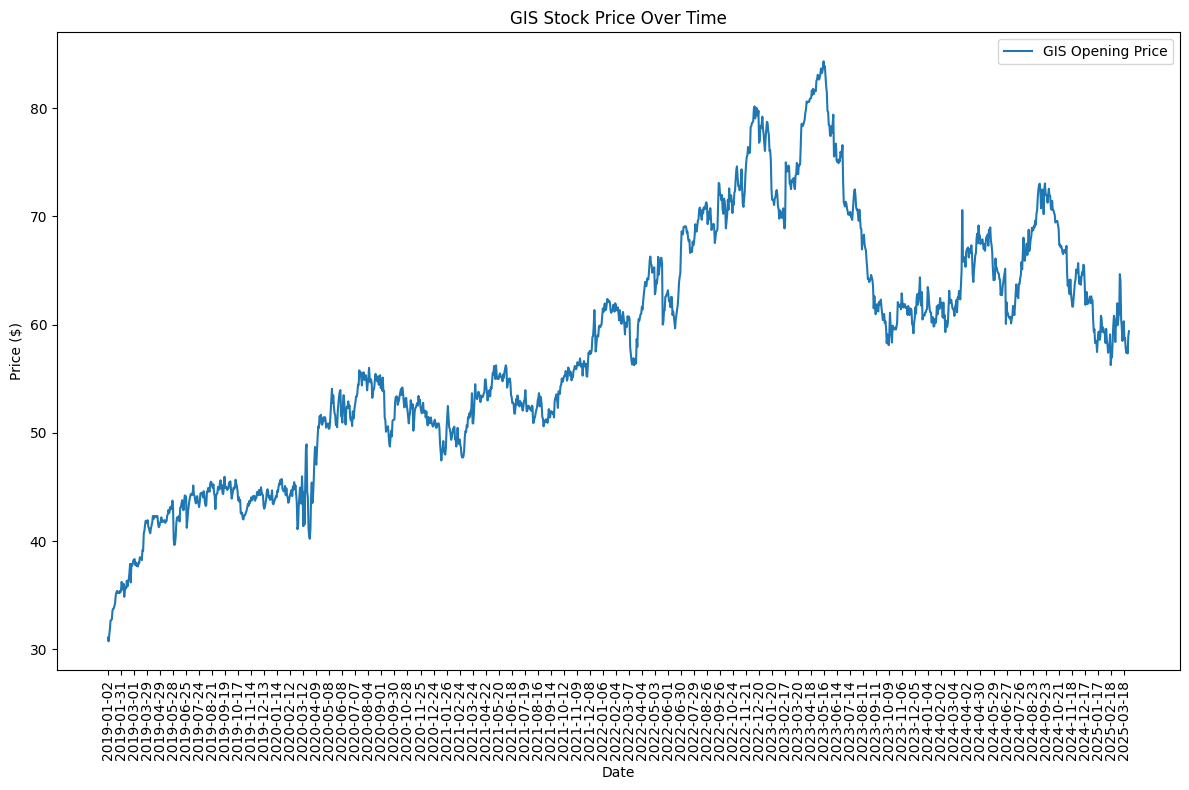

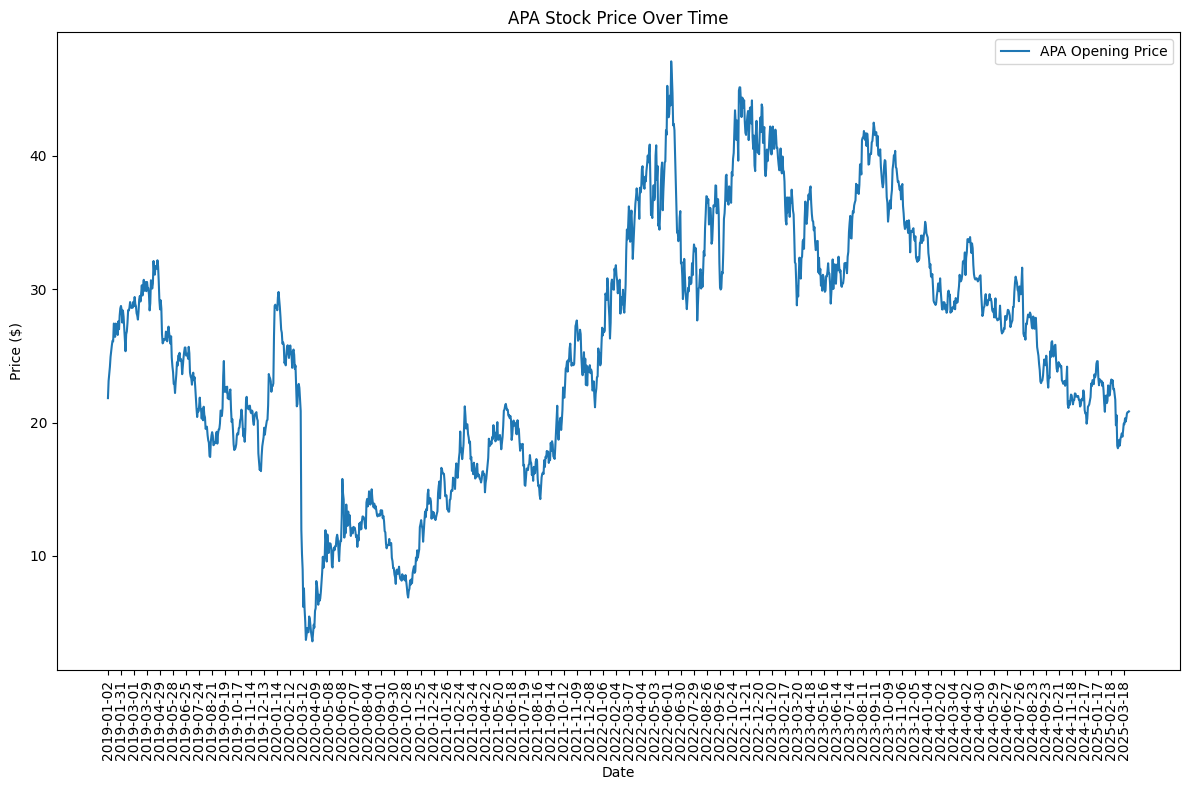

In [11]:

ticker_df = pd.read_csv('ticker_data.csv')
tickers = ['GIS','APA']
%matplotlib inline

for i, ticker in enumerate(tickers, 1):
    plt.figure(figsize=(12,8))
    
    temp = ticker_df[ticker_df['Ticker'] == ticker]
    temp = temp.set_index('Date')
    plt.plot(temp.index, temp['Open'], label=f'{ticker} Opening Price')
    plt.title(f'{ticker} Stock Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=90)  # Rotate x-axis labels 90 degrees
    plt.xticks(plt.xticks()[0][::20])  # Show every 20th tick mark
    plt.legend()  # Add legend since we set a label
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
from scipy.stats import norm
from datetime import datetime, timedelta

# Get GIS data and calculate required parameters
stock = 'AAPL'
r = 0.05  # Risk-free rate (assumed 5%)
T = 1/12  # Time horizon (2 months)
days = 30
n_simulations = 1000

gis_data = ticker_df[ticker_df['Ticker'] == stock].copy()
gis_data['Returns'] = np.log(gis_data['Close']/gis_data['Close'].shift(1))

# # Calculate parameters
S0 = gis_data['Close'].iloc[-1]  
sigma = np.std(gis_data['Returns'].dropna()) * np.sqrt(252)  # Annual volatility (252 trading days per year)


# # Generate time points for prediction (daily for 2 months)
t = np.linspace(0, T, days)

# # Black-Scholes predicted price paths
Z = np.random.standard_normal((n_simulations, days))
# # Fix broadcasting issue by transposing t array
S = S0 * np.exp((r - 0.5 * sigma**2) * t[None, :] + sigma * np.sqrt(t)[None, :] * Z)

# # Calculate confidence intervals
lower_bound = np.percentile(S, 5, axis=0)
upper_bound = np.percentile(S, 95, axis=0)
mean_path = np.mean(S, axis=0)

# # Plot results
plt.figure(figsize = (10,5))
gis_data_LD = gis_data.iloc[-days:]
gis_data_LD
plt.plot(pd.to_datetime(gis_data_LD['Date']), gis_data_LD['Close'], label='Historical Data')
future_dates = pd.date_range(start=pd.to_datetime(gis_data_LD.iloc[-1]['Date']), periods=days+1, freq='D')[1:]
plt.plot(future_dates, mean_path, label='Mean Prediction')

plt.fill_between(future_dates, lower_bound, upper_bound, color='gray', alpha=0.2, label=f'90% Confidence Interval')

plt.title(f'{stock} Stock Price Prediction using Black-Scholes Model')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show();

print(f"Current {stock} Price: ${S0:.2f}")
print(f"Predicted Price Range after 2 months:")
print(f"Lower bound (5th percentile): ${lower_bound[-1]:.2f}")
print(f"Mean prediction: ${mean_path[-1]:.2f}")
print(f"Upper bound (95th percentile): ${upper_bound[-1]:.2f}")


In [ ]:
def add_seasonality(data, seasonality, amplitude, amplitude_noise = 1, noise = 1):
    for i in range(len(data)):
        amplitude = np.random.normal(amplitude, amplitude_noise)
        data[i] = data[i] + amplitude*np.sin(2*np.pi*i/seasonality) + np.random.normal(0, noise)
    return data


def add_slope(data, intercept, intercept_noise, slope, slope_noise = 1, noise = 1):
    for i in range(len(data)):
        slope = np.random.normal(slope, slope_noise)
        intercept = np.random.normal(intercept, intercept_noise)
        if i == 0:
            data[i] = data[i] + intercept + np.random.normal(0, noise)
        else:
            data[i] = data[i] + slope*i + np.random.normal(0, noise)
    return data 
    # y_t = intercept + np.arange(len(data)) * slope + np.random.normal(0, intercept_noise, len(data))
    # return y_t + ar1_data

def generate_ar_process(coeffs, warmup=50, steps=150, intercept=10, noise=0.5, random=False, num_coeff = 0):
    """
    Generate an autoregressive process based on provided coefficients.
    
    Parameters:
    - coeffs: List of AR coefficients
    - warmup: Number of warmup steps to discard
    - steps: Number of steps to keep
    - intercept: Baseline value
    - noise: Standard deviation of random noise
    - random: If True, generates random coefficients between -0.5 and 0.5
    
    Returns:
    - ar_data: Generated time series data
    """
    if random:
        coeffs = np.random.uniform(-0.99, 0.99, num_coeff)
        print(f"Generated random coefficients: {coeffs}")
    
    # Number of lags is determined by the length of coeffs
    n_lags = len(coeffs)
    
    # Initialize array for the entire process
    draws = np.zeros(warmup + steps)
    
    # Initialize first n_lags values to the intercept
    draws[:n_lags] = intercept
    
    # Generate the AR process: each value depends on previous values
    for step in range(n_lags, warmup + steps):
        # Start with intercept
        value = intercept
        
        # Add contribution from each lag
        for i, coef in enumerate(coeffs):
            value += coef * draws[step - i - 1]
        
        # Add random noise
        value += np.random.normal(0, noise)
        
        draws[step] = value
        
    # Return only the non-warmup portion
    return draws[warmup:]


def add_seasonality(data, seasonality, amplitude, noise = 1):
    y_t = amplitude * np.sin(2 * np.pi * np.arange(len(data)) / seasonality) + np.random.normal(0, noise, len(data))
    return y_t + data


# Generate the AR process
ar1_data = generate_ar_process(coeffs, warmup, steps, intercept, noise, random=random, num_coeff = num_coeff)


slope_intercept = 2
slope_intercept_noise = 0
slope_coeff = 1
slope_coeff_noise = 0.54


warmup = 100
steps = 300
intercept = 10
noise = 5
coeffs = [-0.9, -0.7] 
num_coeff = len(coeffs)
random = False





seasonality = 12
seasonality_amplitude = 120
seasonality_amplitude_noise = 0
seasonality_noise = 35
ticker = 'NVDA'


ar1_data = add_slope(ar1_data, intercept = slope_intercept, intercept_noise = slope_intercept_noise, slope = slope_coeff, slope_noise = slope_coeff_noise, noise = 0)
ar1_data = add_seasonality(ar1_data, seasonality = seasonality, amplitude = seasonality_amplitude, noise = seasonality_noise)
end_date = pd.to_datetime('2025-05-27')
start_date = end_date - pd.Timedelta(days=steps)

ar1_data = yf.download(ticker, start=start_date, end=end_date, multi_level_index=False)['Close'].values
# Create a figure to visualize the simulated time series
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title(f"{ticker} Timeseries", fontsize=15)
# Create date range for x-axis
date_range = pd.date_range(start=start_date, end=end_date, periods=len(ar1_data))
ax.plot(date_range, ar1_data)  # Plot the data with dates on x-axis
ax.tick_params(axis='x', rotation=45)  # Rotate date labels for better readability
ax.set_xlabel('Date')  # Add x-axis label
plt.show()  # Display the plot

In [ ]:
import numpy as np
import pymc as pm
import pytensor


arx = 3
priors = {
    "coefs": {"mu": np.zeros(arx + 1), "sigma": np.ones(arx + 1) * 10, "size": arx + 1},
    "sigma": 8,
    "init": {"mu": 9, "sigma": 0.1, "size": 1},
    "alpha": {"mu": -0.3, "sigma": 0.1},
    "beta": {"mu": 0.3, "sigma": 0.2},
    "seasonality": {"mu": 0, "sigma": 0.1}
}
add_trend = True
add_seasonality = False

with pm.Model() as AR:
    t_data = list(range(len(ar1_data)))
    AR.add_coord("obs_id", t_data)
    
    t = pm.Data("t", t_data, dims="obs_id")
    y = pm.Data("y", ar1_data, dims="obs_id")
    coefs = pm.Normal("coefs", priors["coefs"]["mu"], priors["coefs"]["sigma"])
    sigma = pm.HalfNormal("sigma", priors["sigma"])
    init = pm.Normal.dist(
        priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
    )
    
    # Calculate steps explicitly to avoid shape attribute access
    steps = len(t_data) - (priors["coefs"]["size"] - 1)
    
    # Explicitly specify ar_order to fix the NotConstantValueError
    ar1 = pm.AR(
        "ar",
        coefs,
        sigma=sigma,
        init_dist=init,
        constant=True,
        steps=steps,
        ar_order=arx,  # Added explicit ar_order parameter
        dims="obs_id",
    )
    
    alpha = pm.Normal("alpha", priors["alpha"]["mu"], priors["alpha"]["sigma"])
    
    if add_trend:
        beta = pm.Normal("beta", priors["beta"]["mu"], priors["beta"]["sigma"])
        trend = pm.Deterministic("trend", alpha + beta * t, dims="obs_id")
        mu = ar1 + trend
        
        if add_seasonality:
            seasonality = pm.Normal("seasonality", priors["seasonality"]["mu"], priors["seasonality"]["sigma"])
            mu = mu + seasonality
            
        outcome = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y, dims="obs_id")
    else:
        outcome = pm.Normal("likelihood", mu=ar1, sigma=sigma, observed=y, dims="obs_id")
        
    idata_ar = pm.sample_prior_predictive()
    idata_ar.extend(pm.sample(500, random_seed=100, target_accept=0.95))
    idata_ar.extend(pm.sample_posterior_predictive(idata_ar))

In [ ]:
import arviz as az
az.summary(idata_ar)


In [ ]:
import arviz as az


def create_figure_layout(arx):
    """
    Create a figure layout for AR model visualization.
    
    Parameters:
    -----------
    arx : int
        The AR order
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    axes : list
        List of axes for parameter plots
    ax_fit : matplotlib.axes.Axes
        Axis for model fit plot
    """
    import matplotlib.pyplot as plt
    
    # Set up the figure for posterior plots
    fig = plt.figure(figsize=(20, 15))

    # Calculate how many rows we need for parameters (max 3 per row)
    param_rows = (arx + 2 + 2) // 3  # +2 for intercept and sigma, then ceiling division
    # Create a GridSpec layout with param_rows + 1 rows (extra row for model fit)
    gs = fig.add_gridspec(param_rows + 1, 3, height_ratios=[1] * param_rows + [1.5])

    # Create axes: one for each coefficient plus sigma
    axes = []
    for i in range(arx + 2):
        row = i // 3
        col = i % 3
        axes.append(fig.add_subplot(gs[row, col]))  # Parameters in rows of 3

    # Add the model fit plot in the last row, spanning all columns
    ax_fit = fig.add_subplot(gs[param_rows, :])  # bottom row spanning all columns for model fit
    
    return fig, axes, ax_fit

def plot_ar_model_results(idata_ar, t_data, ar1_data, priors, add_trend_coeffs = False, arx=5, view_prev = None):
    """
    Plot the posterior distributions and model fit for an AR model.
    
    Parameters:
    -----------
    idata_ar : InferenceData
        The inference data containing posterior samples and posterior predictive samples
    t_data : list or array
        Time points for the observed data
    ar1_data : list or array
        The observed time series data
    priors : dict
        Dictionary containing prior information
    arx : int, optional
        The AR order (default=5)
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object with all plots
    """
    import matplotlib.pyplot as plt
    if add_trend_coeffs:
        arx += 4
    fig, axes, ax_fit = create_figure_layout(arx)
    plot_posterior_parameters(idata_ar, axes, arx, priors, add_trend_coeffs)
    posterior_pred = plot_model_fit(idata_ar, t_data, ar1_data, ax_fit, view_prev = view_prev)
    plt.tight_layout()
    plt.show() 
    return fig, posterior_pred
def plot_posterior_parameters(idata_ar, axes, arx, priors, add_trend_coeffs = False):
    """
    Plot the posterior distributions of model parameters.
    
    Parameters:
    -----------
    idata_ar : InferenceData
        The inference data containing posterior samples
    axes : list
        List of matplotlib axes to plot on
    arx : int
        The AR order
    priors : dict
        Dictionary containing prior information
    """
    az.plot_posterior(idata_ar, var_names=["coefs"], coords={"coefs_dim_0": 0}, ax=axes[0])
    axes[0].set_title("Intercept")
    for i in range(1, arx-1):
        if i <= priors["coefs"]["size"] - 1:  # Check if coefficient exists in the model
            az.plot_posterior(idata_ar, var_names=["coefs"], coords={"coefs_dim_0": i}, ax=axes[i])
            axes[i].set_title(f"AR({i}) Coefficient")
    # Plot trend coefficients (alpha and beta)
    if add_trend_coeffs:
        az.plot_posterior(idata_ar, var_names=["alpha"], ax=axes[arx-1])
        axes[arx-1].set_title("Alpha (Trend Intercept)")
        az.plot_posterior(idata_ar, var_names=["beta"], ax=axes[arx])
        axes[arx].set_title("Beta (Trend Slope)")

    az.plot_posterior(idata_ar, var_names=["sigma"], ax=axes[arx+1])
    axes[arx+1].set_title("Sigma")
    # Plot sigma

def plot_model_fit(idata_ar, t_data, ar1_data, ax, view_prev = None):
    """
    Plot the model fit against the data.
    
    Parameters:
    -----------
    idata_ar : InferenceData
        The inference data containing posterior predictive samples
    t_data : list or array
        Time points for the observed data
    ar1_data : list or array
        The observed time series data
    ax : matplotlib.axes.Axes
        The axis to plot on
    """
    if not view_prev:
        view_prev = len(t_data)
    ax.plot(t_data[-view_prev:], ar1_data[-view_prev:], 'o', color='black', alpha=0.6, label='Observed data')
    posterior_pred = idata_ar.posterior_predictive["likelihood"].values
    n_samples = 100
    sample_idx = np.random.choice(posterior_pred.shape[0] * posterior_pred.shape[1], n_samples, replace=False)
    for idx in sample_idx:
        chain_idx, draw_idx = idx // posterior_pred.shape[1], idx % posterior_pred.shape[1]
        ax.plot(t_data[-view_prev:], posterior_pred[chain_idx, draw_idx][-view_prev:], color='blue', alpha=0.1)

    # # Plot the mean of the posterior predictive
    posterior_pred_mean = posterior_pred.mean(axis=(0, 1))
    ax.plot(t_data[-view_prev:], posterior_pred_mean[-view_prev:], color='red', linewidth=2, label='Posterior mean')

    ax.set_title('NVDA Stock - Model Fit')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    return posterior_pred

fig, posterior_pred = plot_ar_model_results(idata_ar, t_data, ar1_data, priors, arx=1, add_trend_coeffs = True, view_prev = 150);

In [ ]:
az.plot_trace(idata_ar, var_names=["coefs"], combined=False, compact=False)
# az.plot_trace(idata_ar, var_names=["ar"], combined=True, compact=True)
az.plot_trace(idata_ar, var_names=["sigma"], kind="rank_bars", combined=False, compact=False);

In [ ]:
from pandas import Timedelta
# Define helper functions for prediction
def setup_future_coordinates(model, data_length, prediction_length):
    """Set up coordinates for future predictions."""
    model.add_coords({"obs_id_fut_1": range(data_length - 1, prediction_length, 1)})
    model.add_coords({"obs_id_fut": range(data_length, prediction_length, 1)})
    return model

def plot_observed_data(ax, t_data, ar1_data, view_prev):
    """Plot the observed data points."""
    ax.plot(t_data[-view_prev:], ar1_data[-view_prev:], '-o', color='black', alpha=0.6, label='Observed data')

def plot_posterior_samples(ax, t_data, posterior_pred, view_prev, n_samples=100, alpha = 0.05):
    """Plot samples from the posterior distribution."""
    sample_idx = np.random.choice(posterior_pred.shape[0] * posterior_pred.shape[1], n_samples, replace=False)
    for idx in sample_idx:
        chain_idx, draw_idx = idx // posterior_pred.shape[1], idx % posterior_pred.shape[1]
        ax.plot(t_data[-view_prev:], posterior_pred[chain_idx, draw_idx][-view_prev:], color='blue', alpha=alpha)

def plot_posterior_mean(ax, t_data, posterior_pred, view_prev):
    """Plot the mean of the posterior predictive distribution."""
    posterior_pred_mean = posterior_pred.mean(axis=(0, 1))
    ax.plot(t_data[-view_prev:], posterior_pred_mean[-view_prev:], color='red', linewidth=2, label='Posterior mean')

def plot_future_samples(ax, future_predictions, t_future, n_samples=100, alpha = 0.05):
    """Plot samples of future predictions."""
    sample_idx = np.random.choice(future_predictions.shape[0] * future_predictions.shape[1], n_samples, replace=False)
    future_pred_mean = future_predictions.mean(axis=(0, 1))
    
    # Calculate max distance for normalization
    all_distances = []
    for idx in sample_idx:
        chain_idx, draw_idx = idx // future_predictions.shape[1], idx % future_predictions.shape[1]
        sample = future_predictions[chain_idx, draw_idx]
        distance = np.mean(np.abs(sample - future_pred_mean))
        all_distances.append(distance)
    
    max_distance = max(all_distances) if all_distances else 1
    
    for idx in sample_idx:
        chain_idx, draw_idx = idx // future_predictions.shape[1], idx % future_predictions.shape[1]
        sample = future_predictions[chain_idx, draw_idx]
        
        # Calculate distance from mean (normalized)
        distance = np.mean(np.abs(sample - future_pred_mean))
        norm_distance = distance / max_distance if max_distance > 0 else 0
        
        # Create a gradient from yellowish (closest) to reddish (middle) to blueish (furthest)
        if norm_distance < 0.5:
            # Yellow to red gradient (0 to 0.5)
            ratio = norm_distance * 2  # Scale to 0-1 range
            color = (1, 1 - ratio, 0)  # Yellow (1,1,0) to Red (1,0,0)
        else:
            # Red to blue gradient (0.5 to 1)
            ratio = (norm_distance - 0.5) * 2  # Scale to 0-1 range
            color = (1 - ratio, 0, ratio)  # Red (1,0,0) to Blue (0,0,1)
        
        ax.plot(t_future, sample, color=color, alpha=alpha)

def plot_future_mean(ax, future_predictions, t_future):
    """Plot the mean of future predictions."""
    future_pred_mean = future_predictions.mean(axis=(0, 1))
    ax.plot(t_future, future_pred_mean, color='green', linewidth=2, label='Future predictions (mean)', marker='o')


def setup_plot_labels(ax, arx):
    """Set up the plot title, labels, and legend."""
    # Fix: plt is a module, not an Axes object. We need to use the ax parameter instead.
    ax.set_title(f'AR({arx}) Model Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()

def predict_future_points(AR, ar1, ar1_data, coefs, sigma, steps, idata_ar, n=10):
    """
    Predict future points in the time series using the AR model.
    
    Parameters:
    -----------
    AR : PyMC model
        The AR model
    ar1 : PyMC variable
        The AR process variable
    ar1_data : array
        The observed data
    coefs : PyMC variable
        The AR coefficients
    sigma : PyMC variable
        The noise standard deviation
    steps : int
        Number of steps in the original data
    idata_ar : InferenceData
        The inference data from model fitting
    n : int, optional
        Number of future points to predict, default is 10
        
    Returns:
    --------
    tuple
        (future_predictions, t_future)
    """
    prediction_length = steps + n
    view_prev = n*3
    n_samples = 100
    
    # Create a new figure for the predictions
    plt.figure(figsize=(15, 5))
    
    # Try to make predictions, handling the case where variables might already exist
    try:
        with AR:
            # First check if coordinates already exist and remove them to avoid duplicates
            if "obs_id_fut_1" in AR.coords:
                AR.coords.pop("obs_id_fut_1")
            if "obs_id_fut" in AR.coords:
                AR.coords.pop("obs_id_fut")
                
            # Setup coordinates for future predictions
            AR.add_coords({"obs_id_fut_1": range(ar1_data.shape[0] - 1, prediction_length, 1)})
            AR.add_coords({"obs_id_fut": range(ar1_data.shape[0], prediction_length, 1)})
            
            # Handle t_fut data variable
            try:
                # Try to remove existing t_fut if it exists
                if 't_fut' in AR.named_vars:
                    AR.named_vars.pop('t_fut')
                t_fut = pm.Data("t_fut", list(range(ar1_data.shape[0], prediction_length, 1)))
            except Exception as e:
                print(f"Error handling t_fut: {e}")
                # Fallback to direct assignment
                t_fut = list(range(ar1_data.shape[0], prediction_length, 1))
                
            # Create the future AR model
            try:
                # Remove existing ar1_fut if it exists
                if 'ar1_fut' in AR.named_vars:
                    AR.named_vars.pop('ar1_fut')
                ar1_fut = pm.AR(
                    "ar1_fut",
                    init_dist=pm.DiracDelta.dist(ar1[..., -1]),
                    rho=coefs,
                    sigma=sigma,
                    constant=True,
                    dims="obs_id_fut_1",
                )
            except Exception as e:
                print(f"Error creating ar1_fut: {e}")
                ar1_fut = AR.named_vars.get('ar1_fut')
           
            # Handle trend and seasonality components
            if 'add_trend' in globals() and add_trend and 'add_seasonality' not in globals():
                print('Adding trend component')
                if 'trend_fut' in AR.named_vars:
                    AR.named_vars.pop('trend_fut')
                trend = pm.Deterministic("trend_fut", alpha + beta * t_fut, dims="obs_id_fut")
                mu = ar1_fut[1:] + trend
                if 'yhat_fut' in AR.named_vars:
                    AR.named_vars.pop('yhat_fut')
                yhat_fut = pm.Normal("yhat_fut", mu=mu, sigma=sigma, dims="obs_id_fut")
            elif 'add_trend' in globals() and 'add_seasonality' in globals() and add_trend and add_seasonality:
                print('Adding trend and seasonality components')
                if 'trend_fut' in AR.named_vars:
                    AR.named_vars.pop('trend_fut')
                if 'seasonality_fut' in AR.named_vars:
                    AR.named_vars.pop('seasonality_fut')
                trend = pm.Deterministic("trend_fut", alpha + beta * t_fut, dims="obs_id_fut")
                seasonality = pm.Deterministic("seasonality_fut", seasonality, dims="obs_id_fut")
                mu = ar1_fut[1:] + trend + seasonality
                if 'yhat_fut' in AR.named_vars:
                    AR.named_vars.pop('yhat_fut')
                yhat_fut = pm.Normal("yhat_fut", mu=mu, sigma=sigma, dims="obs_id_fut")
            else:
                print('Using basic AR model without trend or seasonality')
                if 'yhat_fut' in AR.named_vars:
                    AR.named_vars.pop('yhat_fut')
                yhat_fut = pm.Normal("yhat_fut", mu=ar1_fut[1:], sigma=sigma, dims="obs_id_fut")
                
            # Sample from the posterior predictive distribution
            idata_preds = pm.sample_posterior_predictive(
                idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True, random_seed=100
            )
    except Exception as e:
        print(f"Error during prediction: {e}")
        # Try a more robust approach if the first attempt fails
        try:
            # Create a new model for predictions to avoid conflicts
            with pm.Model() as pred_model:
                # Set up coordinates
                pred_model.add_coords({"obs_id_fut_1": range(ar1_data.shape[0] - 1, prediction_length, 1)})
                pred_model.add_coords({"obs_id_fut": range(ar1_data.shape[0], prediction_length, 1)})
                
                # Get posterior samples
                posterior_samples = idata_ar.posterior
                
                # Extract parameters from posterior
                coefs_samples = posterior_samples.coefs.values
                sigma_samples = posterior_samples.sigma.values
                
                # Create deterministic variables for predictions
                ar_init = pm.ConstantData("ar_init", ar1[..., -1].eval())
                
                # Create AR process
                ar1_fut = pm.AR(
                    "ar1_fut",
                    init_dist=pm.DiracDelta.dist(ar_init),
                    rho=coefs_samples.mean(axis=(0, 1)),  # Use mean of posterior
                    sigma=sigma_samples.mean(axis=(0, 1)),  # Use mean of posterior
                    constant=True,
                    dims="obs_id_fut_1",
                )
                
                # Create predictions
                yhat_fut = pm.Normal("yhat_fut", mu=ar1_fut[1:], sigma=sigma_samples.mean(axis=(0, 1)), dims="obs_id_fut")
                
                # Sample from the posterior predictive
                idata_preds = pm.sample_posterior_predictive(
                    posterior_samples, var_names=["yhat_fut"], predictions=True, random_seed=100
                )
        except Exception as nested_e:
            print(f"Fallback prediction approach also failed: {nested_e}")
            raise RuntimeError(f"Could not generate predictions: {e}\nNested error: {nested_e}")
    
    # Extract future predictions
    future_predictions = idata_preds.predictions["yhat_fut"].values
    t_future = np.arange(ar1_data.shape[0], prediction_length)
    
    return future_predictions, t_future

# Predict the next 10 points in the time series
n = 15
future_predictions, t_future = predict_future_points(AR = AR, ar1 = ar1, ar1_data = ar1_data, coefs = coefs, sigma = sigma, steps = len(ar1_data), idata_ar = idata_ar, n=n)
view_prev = n*4
n_samples = 500
alpha = 0.05

end_date = pd.to_datetime('2025-05-27')
start_date = end_date - pd.Timedelta(days=steps)
forecast_start = end_date + pd.Timedelta(days=0)
forecast_end = end_date + pd.Timedelta(days=n-1)
fig, ax = plt.subplots(figsize=(10, 6))

# # Plot the data and predictions
from pandas import date_range
dr = date_range(start_date, end_date)
fr = date_range(forecast_start, forecast_end)
plot_posterior_samples(ax, dr, posterior_pred, view_prev, n_samples, alpha = alpha)
# plot_posterior_mean(ax, t_data, posterior_pred, view_prev)
plot_future_samples(ax, future_predictions, fr, n_samples, alpha = alpha)
plot_future_mean(ax, future_predictions, fr)
ax.axvline(x=min(fr), color='red', linestyle='--', alpha=0.5)
plot_observed_data(ax, dr, ar1_data, view_prev)
setup_plot_labels(ax, arx)

plt.tight_layout()
plt.show()


# Sin Cos PyMC

In [ ]:
from tracemalloc import start
from pandas import Timedelta
import yfinance as yf
from datetime import datetime 

days = 60
end_date = datetime.now() - Timedelta(days=1)
start_date = end_date - Timedelta(days=days)
end_date = end_date.strftime('%Y-%m-%d')
start_date = start_date.strftime('%Y-%m-%d')
df = yf.download('META', start=start_date,end=end_date, multi_level_index=False, interval='1h').reset_index()
df['Datetime'] = pd.to_datetime(df['Datetime'], format = '%Y-%m-%d %HH')
y = (df['Close'] - df['Open'])*100/df['Open']
y
plt.figure(figsize = (15,5))
plt.plot(y)

In [ ]:
import matplotlib.pyplot as plt
from math import sin, cos
import numpy as np

amp1 = 1
amp2 = 2
f1 = 1
f2 = 8

gradient = 0.8

noise_mean = 0
noise_sd = 1

n = 500
x = np.linspace(0,2*np.pi, n)  # Use numpy array instead of list comprehension
noise = np.random.normal(noise_mean, noise_sd, len(x))
y = amp1 * np.sin((f1) * x) + amp2 * np.cos((f2) * x) + noise  # Use numpy's sin/cos functions with added noise
y = y + gradient*x

plt.figure(figsize=(15,5))
plt.plot(x, y, 'b-', linewidth=1.5, alpha=0.8, label='Synthetic Data')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Synthetic Time Series with Sinusoidal Components', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()

In [ ]:

import arviz as az
import pymc  as pm


# Define the model
with pm.Model() as model:
    # Priors for amplitudes and frequencies
    amp1 = pm.Normal('amp1', mu=1.0, sigma=1)
    amp2 = pm.Normal('amp2', mu=1.0, sigma=1)
    f1 = pm.Normal('f1', mu=5.0, sigma=5)
    f2 = pm.Normal('f2', mu=5.0, sigma=5)
    gradient = pm.Normal('gradient', mu = 1, sigma = 1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    # Expected value
    mu = amp1 * pm.math.sin((f1) * x) + amp2 * pm.math.cos((f2) * x) + gradient*x #+ coeff_dow*df['day_of_week'].values + coeff_month*df['month'].values
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
    
    # Sample from the posterior
    idata = pm.sample(1000, tune=1000, return_inferencedata=True)

    # Plot the results
    # az.plot_trace(idata)
    # plt.show()

    # Generate predictions
    with model:
        posterior_pred = pm.sample_posterior_predictive(idata)


az.summary(idata)

In [ ]:
import matplotlib.cm as cm

def color_from_float(value):
    """Returns an RGB tuple (ranging from 0 to 1) for a given float value using a red to blue colormap."""
    # Create a custom colormap from red to blue
    if value < 0.5:
        # Red to white (0 to 0.5)
        r = 1.0
        g = value * 2
        b = min(value * 2 + 0.3, 1.0)  # Ensure blue doesn't exceed 1.0
    else:
        # White to blue (0.5 to 1)
        r = max(2 * (1 - value), 0.0)  # Ensure red doesn't go below 0.0
        g = max(2 * (1 - value), 0.0)  # Ensure green doesn't go below 0.0
        b = 1.0
    return (r, g, b)


samples = 1000
# Plot in-sample predictions
plt.figure(figsize=(15, 5))
plt.plot(x, y, 'k.', alpha=0.5, label='Observed data')
mean_prediction = posterior_pred.posterior_predictive.mean(['draw','chain']).likelihood
distances = []
for i in range(samples):
    distance = abs(float(np.mean(posterior_pred.posterior_predictive.mean(['chain']).likelihood[i] - mean_prediction)))
    distances.append(distance)

# Normalize distances to range [0,1]
max_distance = max(distances)
min_distance = min(distances)
normalized_distances = [(d - min_distance) / (max_distance - min_distance) for d in distances]

# Plot individual posterior draws with color gradient
for i in range(samples):
    color = color_from_float(normalized_distances[i])
    plt.plot(x, posterior_pred.posterior_predictive.mean(['chain']).likelihood[i], '-', alpha=0.01, color=color)
# Plot mean prediction
plt.plot(x, posterior_pred.posterior_predictive.mean(['draw','chain']).likelihood, 'k-', label='Mean prediction', linewidth=2)
plt.legend()
plt.title('In-sample Predictions')
plt.show()

In [ ]:


# Example usage
normalized_value = 0.75
color = color_from_float(normalized_value)
print(color)


In [ ]:
# Plot posterior draws alongside actual data
plt.figure(figsize=(15, 5))

# Plot actual data points
plt.plot(x, y, 'k.', alpha=0.5, label='Observed data')

# Plot mean of posterior predictions
plt.plot(x, posterior_pred['likelihood'].mean(axis=0), 'r-', label='Mean prediction')

# Plot individual posterior draws (first 50 draws for clarity)
for i in range(50):
    plt.plot(x, posterior_pred['likelihood'][i], 'b-', alpha=0.1)

plt.legend()
plt.title('Posterior Draws vs Actual Data')
plt.show()

# Testing

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io


In [ ]:
import pandas_datareader.data as web
symbol = 'WIKI/AAPL'  # or 'AAPL.US'
df = web.DataReader(symbol, 'quandl', '2015-01-01', '2015-01-05')
df.loc['2015-01-02']


In [ ]:
yf.Ticker("AAPL").cashflow

## Volatility Analysis

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

def download_and_analyze_hourly_data(ticker='META', start_date='2023-04-15', end_date='2024-04-01'):
    """
    Download hourly stock data and calculate high/low percentage changes from open price.
    
    Parameters:
    -----------
    ticker : str
        Stock ticker symbol
    start_date : str
        Start date in YYYY-MM-DD format
    end_date : str
        End date in YYYY-MM-DD format
        
    Returns:
    --------
    pandas.DataFrame
        Processed hourly stock data with High/Low as percentage changes from open
    """
    # Download hourly data
    stock_data = yf.download(ticker, start=start_date, end=end_date, 
                            multi_level_index=False, interval='1h')
    
    # Extract date from datetime index
    stock_data['Date'] = stock_data.index.date
    
    # Convert High/Low to percentage change from Open
    stock_data['High'] = np.round(stock_data['High']*100/stock_data['Open'],2) - 100
    stock_data['Low'] = np.round(stock_data['Low']*100/stock_data['Open'],2) - 100
    
    return stock_data

def calculate_hourly_range_stats(stock_data):
    """
    Calculate daily statistics of hourly price ranges.
    
    Parameters:
    -----------
    stock_data : pandas.DataFrame
        Processed stock data with High/Low as percentage changes
        
    Returns:
    --------
    pandas.DataFrame
        Daily statistics of hourly price ranges
    """
    temp = stock_data.reset_index().drop(columns=['Datetime']).set_index('Date')[['High','Low']]
    temp['Hourly Range'] = temp['High'] - temp['Low']
    return temp.groupby('Date').agg({'Hourly Range':['mean','std']})

def plot_hourly_range_with_price_subplots(hourly_stats, daily_data, ticker='META'):
    """
    Create attractive subplots showing both the standard deviation of hourly price ranges
    and the daily stock price.
    
    Parameters:
    -----------
    hourly_stats : pandas.DataFrame
        Daily statistics of hourly price ranges
    daily_data : pandas.DataFrame
        Daily stock price data
    ticker : str
        Stock ticker symbol for title
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    # Extract the standard deviation of hourly range
    hourly_range_std = hourly_stats['Hourly Range']['std']
    
    # Set the style for a more modern look
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), dpi=100, facecolor='white', 
                                   sharex=True, gridspec_kw={'height_ratios': [1, 1.5]})
    
    # Plot hourly range std on top subplot
    ax1.plot(hourly_range_std.index, hourly_range_std.values, 
             color='#3366CC', linewidth=2.5, alpha=0.9)
    
    # Add a subtle shadow/area under the line
    ax1.fill_between(hourly_range_std.index, hourly_range_std.values, 
                     alpha=0.2, color='#3366CC')
    
    # Plot daily closing price on bottom subplot
    ax2.plot(daily_data.index, daily_data['Close'], 
             color='#FF6600', linewidth=1, alpha=0.9)
    
    # Add candlestick-like elements to show daily range
    for idx, row in daily_data.iterrows():
        ax2.vlines(idx, row['Low'], row['High'], color='#FF6600', alpha=0.5, linewidth=1.5)
    
    # Add a subtle shadow/area under the price line
    ax2.fill_between(daily_data.index, daily_data['Close'], 
                     min(daily_data['Low']), alpha=0.1, color='#FF6600')

    # Improve the date formatting on x-axis
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)

    # Add title and labels with better styling
    fig.suptitle(f'{ticker} Price and Intraday Volatility', fontsize=16, fontweight='bold', y=0.98)
    ax1.set_title('Hourly Price Range Volatility', fontsize=12, pad=10)
    ax2.set_title('Daily Stock Price', fontsize=12, pad=10)
    
    ax2.set_xlabel('Date', fontsize=12, labelpad=10)
    ax1.set_ylabel('Std Dev of Hourly Range (%)', fontsize=12, labelpad=10, color='#3366CC')
    ax2.set_ylabel('Stock Price ($)', fontsize=12, labelpad=10, color='#FF6600')
    
    # Set tick colors to match the lines
    ax1.tick_params(axis='y', colors='#3366CC')
    ax2.tick_params(axis='y', colors='#FF6600')

    # Add grid but make it subtle
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax2.grid(True, alpha=0.3, linestyle='--')

    # Add annotations for maximum volatility value
    max_idx = hourly_range_std.idxmax()
    max_val = hourly_range_std.max()
    ax1.scatter(max_idx, max_val, color='red', s=80, zorder=5)
    ax1.annotate(f'Max Volatility: {max_val:.2f}%', 
                 xy=(max_idx, max_val),
                 xytext=(10, -15),
                 textcoords='offset points',
                 fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7))
    
    # Find corresponding price at max volatility
    if max_idx in daily_data.index:
        max_price = daily_data.loc[max_idx, 'Close']
        ax2.scatter(max_idx, max_price, color='red', s=80, zorder=5)
        ax2.annotate(f'Price: ${max_price:.2f}', 
                    xy=(max_idx, max_price),
                    xytext=(10, 15),
                    textcoords='offset points',
                    fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7))

    # Add a subtle border
    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_edgecolor('#CCCCCC')
        
    plt.tight_layout()
    return fig
def plot_smoothed_data(data, ma_windows=[3, 5], ema_spans=[5], figsize=(10, 6), remove_raw_data=False):
    # Create a copy of the data to avoid modifying the original
    data_copy = data.copy()
    
    # Ensure Date is set as the index for proper time series operations
    if 'Date' in data_copy.columns:
        data_copy.set_index('Date', inplace=True)
    
    # Ensure 'Hourly Range' is numeric
    data_copy['Hourly Range'] = pd.to_numeric(data_copy['Hourly Range'], errors='coerce')
    
    timeseries = {}
    plt.figure(figsize=figsize)
    
    # Plot raw data
    if not remove_raw_data:
        plt.plot(data_copy.index, data_copy['Hourly Range'], color='red', linewidth=2, label='Raw Data')
    timeseries['RawData'] = data_copy
    
    # Plot moving averages
    for window in ma_windows:
        ma = data_copy['Hourly Range'].rolling(window=window).mean()
        plt.plot(data_copy.index, ma, linewidth=1.5, label=f'{window}-Day MA')
        timeseries[f'{window}-Day MA'] = ma
    
    # Plot exponential moving averages
    for span in ema_spans:
        ema = data_copy['Hourly Range'].ewm(span=span, adjust=False).mean()
        plt.plot(data_copy.index, ema, linewidth=1.5, label=f'EMA (span={span})')
        timeseries[f'EMA (span={span})'] = ema
    
    plt.title('Standard Deviation of Hourly Range by Date')
    plt.xlabel('Date')
    plt.ylabel('Standard Deviation of Hourly Range')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return timeseries

def find_best_arima_model(time_series, p_values=range(0, 6), d_values=range(0, 2), q_values=range(0, 6)):
    """
    Perform a grid search to find the best ARIMA model parameters based on RMSE.
    
    Parameters:
    -----------
    time_series : pandas.Series
        The time series data to model
    p_values : iterable
        Range of p values to test (AR order)
    d_values : iterable
        Range of d values to test (differencing)
    q_values : iterable
        Range of q values to test (MA order)
    
    Returns:
    --------
    statsmodels.tsa.arima.model.ARIMAResults
        The fitted ARIMA model
    """
    # Drop NaN values for model fitting
    time_series = time_series.dropna()
    
    best_score = float('inf')
    best_order = None
    best_model = None
    best_rmse = float('inf')
    
    # Suppress warnings during grid search
    warnings.filterwarnings("ignore")
    
    # Split data for training and testing (80% train, 20% test)
    train_size = int(len(time_series) * 0.8)
    train, test = time_series[:train_size], time_series[train_size:]
    
    print(f"Grid searching for best ARIMA model parameters...")
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    # Fit the model
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()
                    
                    # Make predictions
                    predictions = model_fit.forecast(steps=len(test))
                    
                    # Calculate RMSE
                    rmse = sqrt(mean_squared_error(test, predictions))
                    
                    # Calculate AIC (Akaike Information Criterion)
                    aic = model_fit.aic
                    
                    # Check if the model produces flat predictions
                    pred_variance = np.var(predictions)
                    if pred_variance < 0.0001:  # Very low variance indicates flat line
                        continue
                    
                    # Use AIC as primary criterion, but also consider RMSE
                    # Lower AIC indicates better model fit with penalty for complexity
                    # This helps avoid overfitting while ensuring realistic predictions
                    if aic < best_score or (abs(aic - best_score) < 2 and rmse < best_rmse):
                        best_score = aic
                        best_rmse = rmse
                        best_order = (p, d, q)
                        best_model = model_fit
                        print(f"New best ARIMA{best_order} - AIC: {aic:.2f}, RMSE: {rmse:.4f}, Var: {pred_variance:.6f}")
                
                except Exception as e:
                    continue
    
    # Re-enable warnings
    warnings.filterwarnings("default")
    
    if best_order is None:
        print("No suitable ARIMA model found. Using default (1,1,1).")
        model = ARIMA(time_series, order=(1, 1, 1))
        best_model = model.fit()
    else:
        print(f"Best ARIMA model: {best_order} with AIC: {best_score:.4f}, RMSE: {best_rmse:.4f}")
        # Fit the best model on the full dataset
        model = ARIMA(time_series, order=best_order)
        best_model = model.fit()
    
    return best_model

def forecast_time_series(timeseries, hourly_range, forecast_days=10, show_plot=True):
    """
    Forecast time series data using ARIMA models.
    
    Parameters:
    -----------
    timeseries : dict
        Dictionary containing time series data
    hourly_range : pandas.DataFrame
        DataFrame containing hourly range data
    forecast_days : int, optional
        Number of days to forecast ahead, by default 10
    show_plot : bool, optional
        Whether to show the plot, by default True
    
    Returns:
    --------
    dict
        Dictionary containing forecasts for each time series
    """
    # Get all time series except RawData
    ts_keys = [i for i in list(timeseries.keys()) if 'RawData' not in i]
    print(ts_keys)
    
    # Calculate the date range for the forecast
    last_date = hourly_range['Date'].max()
    date_range = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days)
    
    # Create a figure for all forecasts if show_plot is True
    if show_plot:
        plt.figure(figsize=(12, 7))
    
    forecasts = {}
    for key in ts_keys:
        # Get the time series data
        ts_data = timeseries[key].dropna()  # Drop NaN values for model fitting
        
        # Fit ARIMA model
        model = find_best_arima_model(ts_data)
        
        # Forecast next period
        forecast = model.forecast(steps=forecast_days)
        forecasts[key] = forecast
        
        if show_plot:
            # Plot only the last 10 days of historical data plus the forecast
            last_10_days = ts_data.iloc[-10:]
            plt.plot(last_10_days.index, last_10_days, label=f'{key} (Historical)', alpha=0.7)
            plt.plot(date_range, forecast, '--', label=f'{key} (Forecast)')
        
        print(f"Forecast for {key}:")
        print(forecast)
        print("-" * 50)
    
    if show_plot:
        plt.title('Time Series Forecasts (1 Month Ahead)')
        plt.xlabel('Date')
        plt.ylabel('Hourly Range')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return forecasts, date_range

def filter_timeseries_keys(timeseries):
    """
    Filter time series keys to get EMA and MA related keys
    
    Parameters:
    -----------
    timeseries : dict
        Dictionary containing the time series data
        
    Returns:
    --------
    tuple
        (ema_keys, ma_keys) - Lists of EMA and MA related keys
    """
    # Get time series keys excluding raw data
    ts_keys = [i for i in list(timeseries.keys()) if 'RawData' not in i]
    
    # Filter keys to get only EMA and MA related forecasts
    ema_keys = [key for key in ts_keys if 'EMA' in key]
    ma_keys = [key for key in ts_keys if 'MA' in key and 'EMA' not in key]
    
    return ema_keys, ma_keys


def setup_forecast_plot():
    """
    Create and setup the figure and axes for forecast plots
    
    Returns:
    --------
    tuple
        (fig, axes) - Figure and axes objects
    """
    # Create a figure with 2 subplots (one for EMA, one for MA)
    fig, axes = plt.subplots(2, 1, figsize=(10, 12), facecolor='#f9f9f9')
    fig.subplots_adjust(hspace=0.3)
    
    return fig, axes


def get_color_palettes(ema_keys, ma_keys):
    """
    Generate color palettes for EMA and MA plots
    
    Parameters:
    -----------
    ema_keys : list
        List of EMA related keys
    ma_keys : list
        List of MA related keys
        
    Returns:
    --------
    tuple
        (ema_colors, ma_colors) - Color palettes for EMA and MA plots
    """
    # Define color palettes for each subplot
    ema_colors = plt.cm.viridis(np.linspace(0, 0.8, len(ema_keys)))
    ma_colors = plt.cm.plasma(np.linspace(0, 0.8, len(ma_keys)))
    
    return ema_colors, ma_colors


def plot_forecast_series(ax, key, historical_data, forecasts, date_range, color, idx):
    """
    Plot a single forecast series with historical data
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on
    key : str
        The key for the time series
    historical_data : pandas.Series
        Historical data for the time series
    forecasts : dict
        Dictionary containing forecast data
    date_range : list
        List of dates for the forecast period
    color : tuple
        RGBA color tuple for the series
    idx : int
        Index of the series in the keys list
    """
    # Prepare combined data for smooth transition
    combined_dates = list(historical_data.index[-10:]) + list(date_range)
    combined_values = list(historical_data[-10:]) + list(forecasts[key])
    
    # Plot historical data with better styling
    ax.plot(historical_data.index[-10:], historical_data[-10:], 
            color=color, linewidth=2.5, label=f'{key} (Historical)', alpha=0.8)
    
    # Plot the combined line with subtle styling
    ax.plot(combined_dates, combined_values, color=color, alpha=0.3, linewidth=1.5)
    
    # Plot forecast with dashed line and better styling
    ax.plot(date_range, forecasts[key], '--', color=color, 
            linewidth=2.5, label=f'{key} (Forecast)')


def add_forecast_start_marker(ax, date_range):
    """
    Add a vertical line and annotation for forecast start
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to add the marker to
    date_range : list
        List of dates for the forecast period
    """
    # Add forecast start line
    ax.axvline(x=date_range[0], color='#444444', linestyle='--', alpha=0.7, 
               linewidth=1.5, label='Forecast Start')
    
    # Add annotation for forecast start
    ax.annotate('Forecast Begins', xy=(date_range[0], ax.get_ylim()[1]*0.95),
                xytext=(date_range[0] - pd.Timedelta(days=1), ax.get_ylim()[1]*0.95),
                arrowprops=dict(arrowstyle='->', color='#444444', lw=1.5),
                fontsize=10, color='#444444')


def add_peak_marker(ax, key, forecasts, date_range, color):
    """
    Add a vertical line and annotation for the peak forecast value
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to add the marker to
    key : str
        The key for the time series
    forecasts : dict
        Dictionary containing forecast data
    date_range : list
        List of dates for the forecast period
    color : tuple
        RGBA color tuple for the series
    """
    # Find peak prediction
    predictions = list(forecasts[key].values)
    max_index = predictions.index(max(predictions))
    max_date = date_range[max_index]
    max_value = predictions[max_index]
    
    # Add vertical line at max prediction
    ax.axvline(x=max_date, color=color, linestyle=':', alpha=0.7, linewidth=1.5)
    
    # Add annotation for peak date
    ax.annotate(f'{key} Peak: {max_date.strftime("%Y-%m-%d")}', 
                xy=(max_date, max_value),
                xytext=(max_date + pd.Timedelta(days=1), max_value),
                arrowprops=dict(arrowstyle='->', color=color, lw=1.5),
                fontsize=9, color=color, fontweight='bold',
                horizontalalignment='left')


def add_forecast_points(ax, key, forecasts, date_range, color, idx, first_series=False):
    """
    Add markers and date labels for forecast points
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to add the points to
    key : str
        The key for the time series
    forecasts : dict
        Dictionary containing forecast data
    date_range : list
        List of dates for the forecast period
    color : tuple
        RGBA color tuple for the series
    idx : int
        Index of the series in the keys list
    first_series : bool, optional
        Whether this is the first series (to add date labels)
    """
    # Add date annotations for all forecast points
    for i, date in enumerate(date_range):
        value = forecasts[key].iloc[i] if hasattr(forecasts[key], 'iloc') else forecasts[key][i]
        
        # Add small markers at each forecast point
        ax.plot(date, value, 'o', color=color, markersize=4)
        
        # Add date labels only for the first series to avoid clutter
        if first_series:
            ax.annotate(date.strftime("%m-%d"), xy=(date, value),
                       xytext=(0, -15), textcoords='offset points',
                       ha='center', va='top', fontsize=8, rotation=45)


def enhance_subplot_styling(ax, title, date_range):
    """
    Enhance the styling of a subplot
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to style
    title : str
        The title for the subplot
    date_range : list
        List of dates for the forecast period
    """
    # Set title and labels
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Hourly Range', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add shaded region for forecast period
    ax.axvspan(date_range[0], date_range[-1], alpha=0.1, color='gray', label='Forecast Period')
    
    # Improve legend
    ax.legend(loc='upper left', frameon=True, framealpha=0.9, fontsize=10)
    
    # Add a subtle border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)


def plot_ema_ma_forecasts(timeseries, forecasts, date_range, forecast_days=10):
    """
    Create subplots for EMA and MA forecasts with improved aesthetics
    
    Parameters:
    -----------
    timeseries : dict
        Dictionary containing the time series data
    forecasts : dict
        Dictionary containing forecast data for each time series
    date_range : list
        List of dates for the forecast period
    forecast_days : int, optional
        Number of days to forecast ahead (default: 10)
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plots
    """
    # Filter keys and setup plot
    ema_keys, ma_keys = filter_timeseries_keys(timeseries)
    fig, axes = setup_forecast_plot()
    ema_colors, ma_colors = get_color_palettes(ema_keys, ma_keys)
    
    # Plot EMA forecasts
    for idx, key in enumerate(ema_keys):
        historical_data = timeseries[key].dropna()
        
        # Plot the series
        plot_forecast_series(axes[0], key, historical_data, forecasts, date_range, ema_colors[idx], idx)
        
        # Add forecast start marker only for the first series
        if idx == 0:
            add_forecast_start_marker(axes[0], date_range)
        
        # Add peak marker and forecast points
        add_peak_marker(axes[0], key, forecasts, date_range, ema_colors[idx])
        add_forecast_points(axes[0], key, forecasts, date_range, ema_colors[idx], idx, idx == 0)
    
    # Plot MA forecasts
    for idx, key in enumerate(ma_keys):
        historical_data = timeseries[key].dropna()
        
        # Plot the series
        plot_forecast_series(axes[1], key, historical_data, forecasts, date_range, ma_colors[idx], idx)
        
        # Add forecast start marker only for the first series
        if idx == 0:
            add_forecast_start_marker(axes[1], date_range)
        
        # Add peak marker and forecast points
        add_peak_marker(axes[1], key, forecasts, date_range, ma_colors[idx])
        add_forecast_points(axes[1], key, forecasts, date_range, ma_colors[idx], idx, idx == 0)
    
    # Enhance styling for both subplots
    enhance_subplot_styling(axes[0], 'EMA Forecasts (10 Days Ahead)', date_range)
    enhance_subplot_styling(axes[1], 'MA Forecasts (10 Days Ahead)', date_range)
    
    plt.tight_layout()
    return fig



In [ ]:
# Configuration dictionary for stock analysis
config = {
    'ticker': 'META',
    'start_date': '2025-02-01',
    'end_date': '2025-05-25',
    'filter_date': '2025-03-01',
    'ma_windows': [2, 5, 10],
    'ema_spans': [2, 5, 10],
    'forecast_days': 10
}

# Download and process data
meta_data = download_and_analyze_hourly_data(config['ticker'], config['start_date'], config['end_date'])
hourly_stats = calculate_hourly_range_stats(meta_data)
daily_data = yf.download(config['ticker'], start=config['start_date'], end=config['end_date'], 
                         interval='1d', multi_level_index=False)

# Create and display the combined subplot visualization
fig = plot_hourly_range_with_price_subplots(hourly_stats, daily_data, config['ticker'])
plt.show()

# Process hourly range data
hourly_range = hourly_stats['Hourly Range']['std']
hourly_range = hourly_range.reset_index()
hourly_range.rename(columns={'std': 'Hourly Range'}, inplace=True)
hourly_range = hourly_range[hourly_range['Date'] >= pd.to_datetime(config['filter_date']).date()]

# Generate time series and forecasts
timeseries = plot_smoothed_data(hourly_range, ma_windows=config['ma_windows'], 
                               ema_spans=config['ema_spans'], remove_raw_data=True)
forecasts, date_range = forecast_time_series(timeseries, hourly_range, forecast_days=config['forecast_days'], show_plot=False)
fig = plot_ema_ma_forecasts(timeseries, forecasts, date_range)
plt.show()

In [ ]:
temp = daily_data.reset_index()
temp['Close'] = temp['Close']/temp['Open']
# Convert Date column in hourly_range to datetime if it's an int
hourly_range_copy = hourly_range.copy()
if hourly_range_copy['Date'].dtype == 'int64':
    hourly_range_copy['Date'] = pd.to_datetime(hourly_range_copy['Date'])
# Or alternatively use pd.concat as suggested by the error
result = pd.concat([temp, hourly_range_copy], axis=1, join='inner')
result[['Close','Hourly Range']].corr()


---
# Fourier Seasonality

In [84]:
import pandas as pd
import pymc as pm
from pymc_marketing.mmm import YearlyFourier

yearly = YearlyFourier(n_order=3)

dates = pd.date_range("2023-01-01", periods=52, freq="W-MON")

dayofyear = dates.dayofyear.to_numpy()

with pm.Model() as model:
    fourier_trend = yearly.apply(dayofyear)


Sampling: [fourier_beta]
Sampling: []


Output()

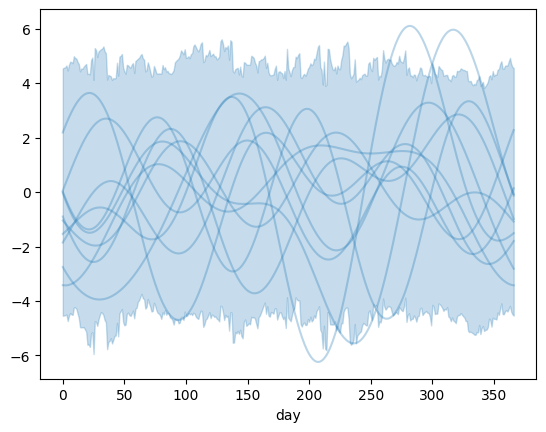

In [91]:
import matplotlib.pyplot as plt

prior = yearly.sample_prior()
curve = yearly.sample_curve(prior)
yearly.plot_curve(curve)
plt.show()

In [92]:
from pymc_marketing.mmm import YearlyFourier
from pymc_marketing.prior import Prior

prior = Prior("Normal", mu=0, sigma=0.10)
yearly = YearlyFourier(n_order=6, prior=prior)

In [93]:
from pymc_marketing.mmm import YearlyFourier
from pymc_marketing.prior import Prior

# "fourier" is the default prefix!
prior = Prior(
    "Laplace",
    mu=Prior("Normal", dims="fourier"),
    b=Prior("HalfNormal", sigma=0.1, dims="fourier"),
    dims=("fourier", "hierarchy"),
)
yearly = YearlyFourier(n_order=3, prior=prior)


Sampling: [fourier_beta, fourier_beta_b, fourier_beta_mu]
Sampling: []


Output()

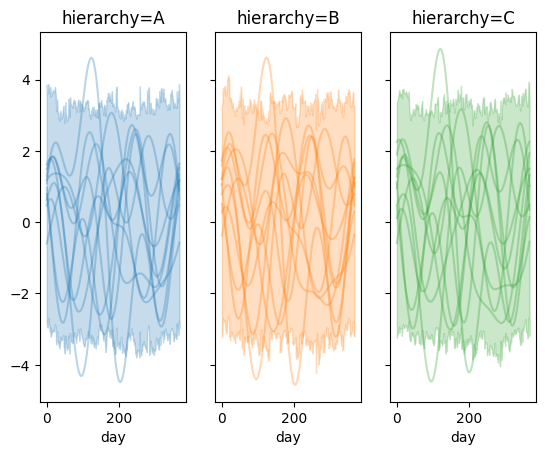

In [97]:
import matplotlib.pyplot as plt
coords = {"hierarchy": ["A", "B", "C"]}
prior = yearly.sample_prior(coords=coords)
curve = yearly.sample_curve(prior)
yearly.plot_curve(curve)
plt.show()

In [98]:
import pandas as pd
import pymc as pm

from pymc_marketing.mmm import YearlyFourier

periods = 52 * 3
dates = pd.date_range("2022-01-01", periods=periods, freq="W-MON")

training_dates = dates[:52 * 2]
testing_dates = dates[52 * 2:]

yearly = YearlyFourier(n_order=3)

coords = {
    "date": training_dates,
}
with pm.Model(coords=coords) as model:
    dayofyear = pm.Data(
        "dayofyear",
        training_dates.dayofyear.to_numpy(),
        dims="date",
    )

    trend = pm.Deterministic(
        "trend",
        yearly.apply(dayofyear),
        dims="date",
    )

    idata = pm.sample_prior_predictive().prior

with model:
    pm.set_data(
        {"dayofyear": testing_dates.dayofyear.to_numpy()},
        coords={"date": testing_dates},
    )

    out_of_sample = pm.sample_posterior_predictive(
        idata,
        var_names=["trend"],
    ).posterior_predictive["trend"]

Sampling: [fourier_beta]
Sampling: []


Output()

In [99]:
import pandas as pd
import pymc as pm

from pymc_marketing.mmm import (
    MonthlyFourier,
    YearlyFourier,
)

yearly = YearlyFourier(n_order=6, prefix="yearly")
monthly = MonthlyFourier(n_order=3, prefix="monthly")

dates = pd.date_range("2023-01-01", periods=52, freq="W-MON")
dayofyear = dates.dayofyear.to_numpy()

coords = {
    "date": dates,
}

with pm.Model(coords=coords) as model:
    yearly_trend = yearly.apply(dayofyear)
    monthly_trend = monthly.apply(dayofyear)

    trend = pm.Deterministic(
        "trend",
        yearly_trend + monthly_trend,
        dims="date",
    )

with model:
    prior_samples = pm.sample_prior_predictive().prior

Sampling: [monthly_beta, yearly_beta]
